In [1]:
from abc import ABC, abstractmethod
from collections import Counter, defaultdict
from dataclasses import dataclass
from enum import Enum
import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random
from typing import Dict, List, Optional, Set, Tuple, Union

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from basic_utils import (
    Box,
    BoxCategories,
    RollAction,
    RollValues,
    ScoreCard,
    roll_first,
    remove_dice,
    roll_again,
    GameState,
)
from agents import Agent, EpsilonGreedyAgent, GreedyAgent, RandomAgent

A state in the game consists of a `ScoreCard` (score card state), `RollValues` (values of dice showing on the table), and `rolls_completed` from 1 to 3 within the turn. The `ScoreCard` contains all needed information from the previous turns. The `RollValues` just contains the values of the five dice that have been rolled at a given point.

`GameState` contains all three of these objects. It provides `possible_score_actions`, which gives the scores possible with a given set of dice values and score card state. I frame these as actions because at any time the player can choose to end their turn and score with one of these values. For convenience, they are sorted in descending order by score. `GameState` also provides `possible_actions`, which includes roll actions in addition to the `possible_score_actions`. The `re_roll` method takes dice that are specified by value and rolls again. Finally, `GameState` provides an `update_score` method, which updates the scorecard given a choice of box.

The current score can be accessed at any time by calling the `score` method of the `GameState`'s `scorecard`.

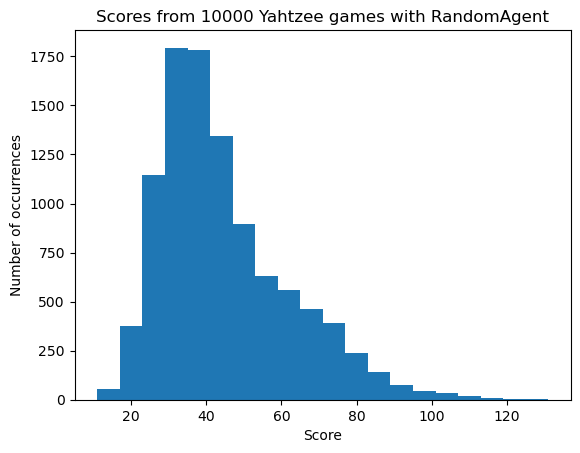

Mean score = 44.2
Standard deviation = 17.3


In [74]:
random_agent_scores = RandomAgent().play_games(n_games=10_000, histogram_bins=20)

The mean score for a `RandomAgent` over 10,000 games is less than 50 - that's pretty bad! There is a long tail on the right, with a few scores above 100 being achieved.

In this first pass at implementing the gameplay actions and scoring, I focused on development speed and cleanliness of the design. I deliberatly did not spend time optimizing for runtime speed, and it shows here, as it took several minutes to simulate 10,000 one-player games. I still think this is OK for now; I can optimize later once I start training some deep RL agents.

Let's try a `GreedyAgent` instead.

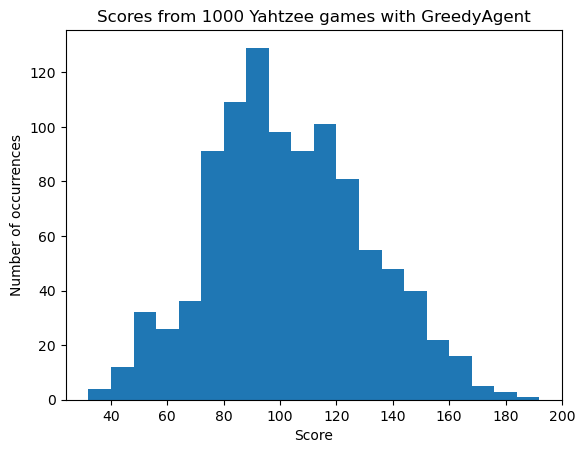

Mean score = 103
Standard deviation = 27.6


In [11]:
greedy_agent_scores = GreedyAgent().play_games(n_games=1000, histogram_bins=20)

In [12]:
sum([1 for s in greedy_agent_scores if s > 150]) / len(greedy_agent_scores)

0.048

The `GreedyAgent` does substantially better: it achieves mean score above 100, in about 5% of games it scores better than 150, and in a few games it even gets close to 200. 

Still, the performance is not great compared to typcial human gameplay. I'm not a terribly skilled player, and my own threshold for a good game is a score around 200.

It's pretty clear that a naive $\epsilon$-greedy agent won't do better. Since dice have no memory, there's no advantage of sometimes taking a `RollAction` instead of the best `ScoreAction`; to do better, we'd have to pick our `RollAction` strategically, not at random. Trying out the naive agent confirms that it's not a better approach:

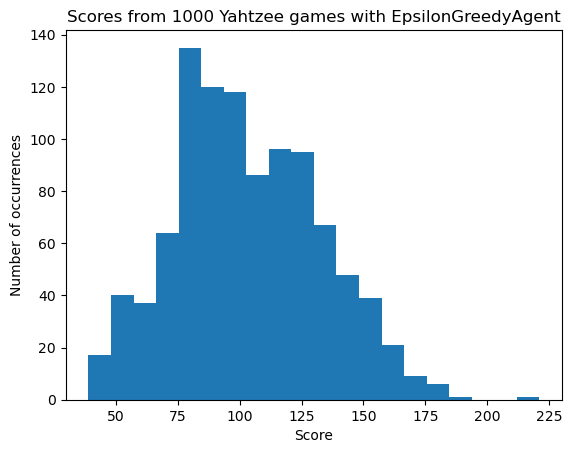

Mean score = 103
Standard deviation = 29.4


In [8]:
epsilon_greedy_agent_scores = EpsilonGreedyAgent(epsilon=0.5).play_games(n_games=1000)

Next I'll try to come up with a reasonably good strategy, similar to the one I try to follow when playing in the real world. Roughly speaking, given the five dice values after the first roll I pick an unused box to "go for" and then roll the dice that maximize the probability of hitting the box (or scoring as high as possible in the box, for the upper section) on this turn. For now let's set aside the question of how to pick which box to go for, and focus on figuring out which dice to roll to hit the box.

Figuring out the best `RollAction` for a small or large straight is not as straightforward (ha) as for the other categories. Given particular `RollValues` it's usually pretty easy to see what to roll, but the casework here could make the function implementation a bit messy. Instead of attempting to write out all the cases, I just precomputed a map from the roll values to the best roll action to take.

In [31]:
df_small_straight = pd.read_csv(f"best_roll_actions_for_{Box.SmallStraight.value}.csv")

In [33]:
df_small_straight["expected_value"] = 30 * df_small_straight["hit_probability"]

In [34]:
df_small_straight.head()

,Unnamed: 0,roll_values,dice_values_to_roll,hit_probability,expected_value
0,0,"(2, 2, 2, 2, 4)","(2, 2, 2)",0.250000,7.500000
1,1,"(3, 4, 5, 5, 5)","(5, 5)",0.555556,16.666667
2,2,"(1, 2, 2, 2, 6)","(1, 2, 2, 2, 6)",0.154321,4.629630
3,3,"(3, 3, 4, 4, 4)","(3, 4, 4)",0.361111,10.833333
4,4,"(2, 5, 5, 6, 6)","(2, 5, 5, 6, 6)",0.154321,4.629630


In [9]:
def load_best_roll_action_tuples(box: Box) -> dict[Tuple[int, ...], Tuple[int, ...]]:
    df = pd.read_csv(f"best_roll_actions_for_{box.value}.csv")
    str_dict = dict(zip(df["roll_values"], df["dice_values_to_roll"]))
    return {eval(k): eval(v) for k, v in str_dict.items()}

In [10]:
SMALL_STRAIGHT_BEST_ACTION_TUPLES = load_best_roll_action_tuples(Box.SmallStraight)
LARGE_STRAIGHT_BEST_ACTION_TUPLES = load_best_roll_action_tuples(Box.LargeStraight)

In [25]:
def best_roll_action_for_box(roll_values: RollValues, box: Box) -> Optional[RollAction]:
    """
    Given a set of dice values and a box, chooses the dice to roll in order to maximize
    the probability of checking the box. If the dice values already hit the box, `None`
    is returned.
    """
    roll_action = None

    upper_box_names = [Box.Ones, Box.Twos, Box.Threes, Box.Fours, Box.Fives, Box.Sixes]
    upper_box_values = [1, 2, 3, 4, 5, 6]
    for box_name, box_value in zip(upper_box_names, upper_box_values):
        if box == box_name:
            roll_action = RollAction(*[v for v in roll_values.values if v != box_value])

    # TODO: Handle the Chance case. For now I just won't roll any dice for this case.
    if roll_values.checks_lower_box(box):
        return None

    if box in {Box.ThreeOfAKind, Box.FourOfAKind, Box.Yahtzee}:
        roll_action = RollAction(*[v for v in roll_values.values if v != roll_values.mode_value()])

    if box == Box.FullHouse:
        if roll_values.checks_lower_box(Box.ThreeOfAKind):
            #  Keep three dice that give ThreeOfAKind, and roll the other two dice
            roll_action = RollAction(*remove_dice(roll_values, tuple(roll_values.mode_value() for _ in range(3))))
        elif 2 in roll_values.value_counts.values():
            # Keep all pairs, and roll the other dice
            roll_action = RollAction(*[v for v in roll_values.values if roll_values.value_counts[v] != 2])
        else:
            # Roll all the dice
            roll_action = RollAction(*roll_values.values)

    if box == Box.SmallStraight:
        roll_action = RollAction(*SMALL_STRAIGHT_BEST_ACTION_TUPLES[roll_values.values])
    
    if box == Box.LargeStraight:
        roll_action = RollAction(*LARGE_STRAIGHT_BEST_ACTION_TUPLES[roll_values.values])
    
    return roll_action

In [14]:
best_roll_action_for_box(RollValues(1, 2, 3, 3, 4), Box.Yahtzee)

RollAction(dice_values_to_roll=(1, 2, 4))

In [15]:
game_state = GameState()

In [26]:
game_state.start_turn()

Roll number 1 gives:
Dice values = 3, 3, 4, 4, 6


In [27]:
for box in BoxCategories.LowerBox:
    print(box.name, best_roll_action_for_box(game_state.roll_values, box))

Chance None
LargeStraight RollAction(dice_values_to_roll=(3, 4))
ThreeOfAKind RollAction(dice_values_to_roll=(3, 3, 6))
Yahtzee RollAction(dice_values_to_roll=(3, 3, 6))
FourOfAKind RollAction(dice_values_to_roll=(3, 3, 6))
SmallStraight RollAction(dice_values_to_roll=(3, 4))
FullHouse RollAction(dice_values_to_roll=(6,))


In [28]:
game_state.take_action(RollAction(3, 4))

Roll number 2 (re-rolling 3, 4) gives:
Dice values = 3, 3, 4, 6, 6


In [29]:
for box in BoxCategories.LowerBox:
    print(box.name, best_roll_action_for_box(game_state.roll_values, box))

Chance None
LargeStraight RollAction(dice_values_to_roll=(3, 6))
ThreeOfAKind RollAction(dice_values_to_roll=(3, 3, 4))
Yahtzee RollAction(dice_values_to_roll=(3, 3, 4))
FourOfAKind RollAction(dice_values_to_roll=(3, 3, 4))
SmallStraight RollAction(dice_values_to_roll=(3, 6))
FullHouse RollAction(dice_values_to_roll=(4,))


In [ ]:
class BasicStrategyAgent(Agent):

    def choose_action(self, game_state: GameState) -> Union[RollAction, ScoreAction]:
        r = random.random()
        if r < self.epsilon and len(game_state.possible_roll_actions) != 0:
            action = random.choice(game_state.possible_roll_actions)
        else:
            action = game_state.possible_score_actions[0]
        return action

I need to compute the expected value of the score gain for these actions.

In [ ]:
def expected_score_gain(roll_value: RollValue, )